In [66]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [67]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

<h1> Pivioting

In [68]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [69]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [70]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [71]:
df_fish = spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_table_year", keyspace="fish_keyspace").load()
df_fish.show()

+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+------------------+----+----+
|localityweekid|avgadultfemalelice|      date|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|municipality|municipalityno|              name|week|year|
+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+------------------+----+----+
|       1639407|              null|2023-09-25|                 false| false|      

In [72]:
# make spark dataframe to pandas dataframe
df_fish = df_fish.toPandas()
df_fish.head()

,localityweekid,avgadultfemalelice,date,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,...,isonland,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year
0,1636961,NaN,2023-09-25,False,False,False,False,False,True,False,...,False,False,60.025583,10054,5.309083,Austevoll,4625,Tobbeholmane,39,2023
1,1501128,NaN,2022-12-05,False,False,False,False,False,True,False,...,True,False,67.278117,10483,14.556850,Bodø,1804,Mørkvedbukta,49,2022
2,1622593,NaN,2023-08-21,False,False,False,True,False,True,False,...,False,False,63.255000,27436,7.856933,Smøla,1573,Solværet,34,2023
3,1503333,0.0,2022-12-12,False,False,False,False,True,True,False,...,False,False,59.399383,11925,6.020533,Suldal,1134,Vintraviki,50,2022
4,1532568,NaN,2023-02-13,False,True,False,False,False,True,False,...,False,False,68.854633,13597,17.520883,Salangen,5417,Salangslia,7,2023


In [73]:
# Create a variable called region, splitting Norway into three regions: South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude.
df_fish['region'] = 'NaN'
df_fish.loc[df_fish['lat'] < 63.81, 'region'] = 'South'
df_fish.loc[(df_fish['lat'] >= 63.81) & (df_fish['lat'] <= 68.85), 'region'] = 'Middle'
df_fish.loc[df_fish['lat'] > 68.85, 'region'] = 'North'
df_fish.head()

,localityweekid,avgadultfemalelice,date,hascleanerfishdeployed,hasila,hasmechanicalremoval,haspd,hasreportedlice,hassalmonoids,hassubstancetreatments,...,isslaughterholdingcage,lat,localityno,lon,municipality,municipalityno,name,week,year,region
0,1636961,NaN,2023-09-25,False,False,False,False,False,True,False,...,False,60.025583,10054,5.309083,Austevoll,4625,Tobbeholmane,39,2023,South
1,1501128,NaN,2022-12-05,False,False,False,False,False,True,False,...,False,67.278117,10483,14.556850,Bodø,1804,Mørkvedbukta,49,2022,Middle
2,1622593,NaN,2023-08-21,False,False,False,True,False,True,False,...,False,63.255000,27436,7.856933,Smøla,1573,Solværet,34,2023,South
3,1503333,0.0,2022-12-12,False,False,False,False,True,True,False,...,False,59.399383,11925,6.020533,Suldal,1134,Vintraviki,50,2022,South
4,1532568,NaN,2023-02-13,False,True,False,False,False,True,False,...,False,68.854633,13597,17.520883,Salangen,5417,Salangslia,7,2023,North


In [74]:
# combine year and week into new column called year_week
df_fish['year_week'] = df_fish['year'].astype(str) + '-' + df_fish['week'].astype(str)

In [75]:
# Create the following "Gropuby"s: category: week and values: avgadultfemalelice
df_fish_grouped = df_fish.groupby('year_week')['avgadultfemalelice'].mean().reset_index(name='avg_adult_female_lice')


In [76]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice
0,2022-45,0.188433
1,2022-46,0.188252
2,2022-47,0.192589
3,2022-48,0.160068
4,2022-49,0.164200


In [77]:
import pandas as pd
# get the first date in each week and add it to the dataframe
df_fish_grouped['date'] = pd.to_datetime(df_fish_grouped['year_week'] + '-1', format="%Y-%W-%w")

# have to groupby year_week since the data spans over two years

In [78]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice,date
0,2022-45,0.188433,2022-11-07
1,2022-46,0.188252,2022-11-14
2,2022-47,0.192589,2022-11-21
3,2022-48,0.160068,2022-11-28
4,2022-49,0.164200,2022-12-05


<Axes: xlabel='date'>

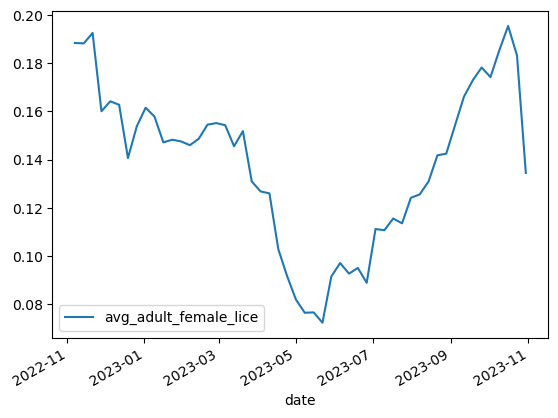

In [79]:
# plot the df_fish_grouped dataframe
import matplotlib.pyplot as plt

df_fish_grouped.plot(x='date', y='avg_adult_female_lice')


In [80]:
# Create the following piviot tables:
# category: haspd and haslla, values: lat

df_fish_pivot = df_fish.pivot_table(index='year_week', values=['haspd', 'hasila'], aggfunc='mean').reset_index()

In [81]:
df_fish_pivot.head()

,year_week,hasila,haspd
0,2022-45,0.006418,0.052509
1,2022-46,0.007585,0.052509
2,2022-47,0.007589,0.053123
3,2022-48,0.008168,0.053092
4,2022-49,0.008149,0.055879


In [82]:
# get the first date in each week and add it to the dataframe
df_fish_pivot['date'] = pd.to_datetime(df_fish_pivot['year_week'] + '-1', format="%Y-%W-%w")

In [83]:
df_fish_pivot.head()

,year_week,hasila,haspd,date
0,2022-45,0.006418,0.052509,2022-11-07
1,2022-46,0.007585,0.052509,2022-11-14
2,2022-47,0.007589,0.053123,2022-11-21
3,2022-48,0.008168,0.053092,2022-11-28
4,2022-49,0.008149,0.055879,2022-12-05


<Axes: xlabel='date'>

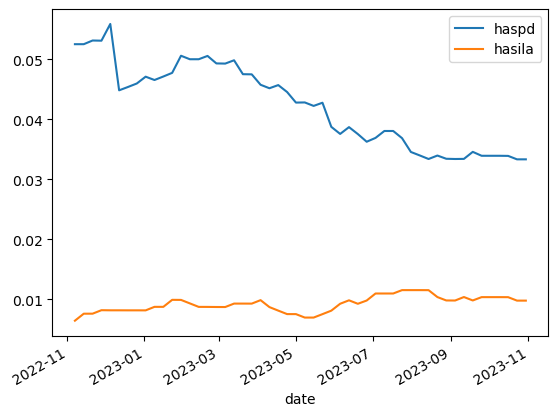

In [84]:
# plot the df_fish_pivot dataframe
df_fish_pivot.plot(x='date', y=['haspd', 'hasila'])

In [85]:
# Create the following piviot tables:
# category: region and year_week, values: avgadultfemalelice

df_fish_pivot2 = df_fish.pivot_table(index=['region', 'year_week'], values='avgadultfemalelice', aggfunc='mean').reset_index()

# get the first date in each week and add it to the dataframe
df_fish_pivot2['date'] = pd.to_datetime(df_fish_pivot2['year_week'] + '-1', format="%Y-%W-%w")

In [86]:
df_fish_pivot2.head()

,region,year_week,avgadultfemalelice,date
0,Middle,2022-45,0.172211,2022-11-07
1,Middle,2022-46,0.169788,2022-11-14
2,Middle,2022-47,0.190543,2022-11-21
3,Middle,2022-48,0.175645,2022-11-28
4,Middle,2022-49,0.169839,2022-12-05


<Axes: xlabel='date', ylabel='avgadultfemalelice'>

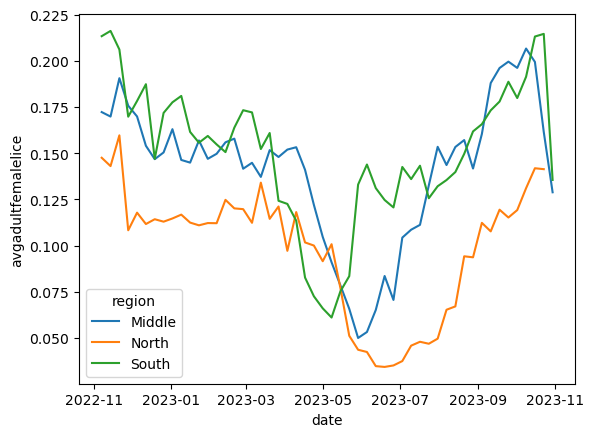

In [87]:
# plot the df_fish_pivot2 dataframe with region as hue
import seaborn as sns
sns.lineplot(data=df_fish_pivot2, x='date', y='avgadultfemalelice', hue='region')



<h1> Forecasting

In [88]:
# Read from Cassandra - lice_count_table
df_lice = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()

# make spark dataframe to pandas dataframe
df_lice = df_lice.toPandas()
df_lice.head()

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,seatemperature,specieslist,week,year
0,2023-04-24,0.02,0.08,0.00,Andholmen 1,6.8,"['Laks', 'Ørret', 'Regnbueørret']",17,2023
1,2022-12-12,0.05,0.22,0.00,Andholmen 1,6.4,"['Laks', 'Ørret', 'Regnbueørret']",50,2022
2,2023-07-03,0.06,0.21,0.01,Andholmen 1,13.2,"['Laks', 'Ørret', 'Regnbueørret']",27,2023
3,2023-01-16,0.08,0.54,0.08,Andholmen 1,6.2,"['Laks', 'Ørret', 'Regnbueørret']",3,2023
4,2023-02-06,0.04,0.20,0.02,Andholmen 1,6.7,"['Laks', 'Ørret', 'Regnbueørret']",6,2023


In [90]:
import pandas as pd

# Assuming df_lice is your DataFrame and it's already been defined

# Create a new column with the lagged sea temperature
df_lice['lagged_sea_temp'] = df_lice['seatemperature'].shift(1)

# Define the window size for the sliding window
window_size = 4  

# Calculate sliding window correlation for lagged sea temperature against each lice category
df_lice['corr_lagged_sea_temp_avgadultfemalelice'] = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgadultfemalelice'])
df_lice['corr_lagged_sea_temp_avgmobilelice'] = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgmobilelice'])
df_lice['corr_lagged_sea_temp_avgstationarylice'] = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgstationarylice'])

In [93]:
import pandas as pd
import numpy as np

# Assuming df_lice is your DataFrame and it's already been defined

# Define the range of lags and window sizes to test
lags = range(0, 5)  # Lags from 0 up to 4 periods
window_sizes = range(2, 6)  # Window sizes from 2 up to 5 periods

# Initialize a list to store correlation results
correlation_results = []

# Iterate over the different lags and window sizes
for window_size in window_sizes:
    for lag in lags:
        # Create a new column with the lagged sea temperature
        df_lice['lagged_sea_temp'] = df_lice['seatemperature'].shift(lag)

        # Calculate sliding window correlation for each lice category
        corr_adult_female = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgadultfemalelice'])
        corr_mobile = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgmobilelice'])
        corr_stationary = df_lice['lagged_sea_temp'].rolling(window=window_size).corr(df_lice['avgstationarylice'])

        # Store the correlation values for each lice category
        correlation_results.append({
            'Window_Size': window_size,
            'Lag': lag,
            'Corr_AdultFemaleLice': corr_adult_female.dropna().mean(),
            'Corr_MobileLice': corr_mobile.dropna().mean(),
            'Corr_StationaryLice': corr_stationary.dropna().mean()
        })

# Convert the list to a DataFrame for easy viewing
correlation_results_df = pd.DataFrame(correlation_results)

# Display the DataFrame sorted by the correlation for AdultFemaleLice, for example
correlation_results_df.sort_values(by='Corr_AdultFemaleLice', ascending=False)


,Window_Size,Lag,Corr_AdultFemaleLice,Corr_MobileLice,Corr_StationaryLice
3,2,3,inf,-inf,NaN
5,3,0,0.541144,0.226464,0.142002
15,5,0,0.534440,0.234537,0.132211
10,4,0,0.501292,0.210795,0.115351
17,5,2,0.067385,0.142177,0.061328
8,3,3,0.041217,0.014526,0.150282
14,4,4,0.033760,-0.118872,-0.170423
12,4,2,0.025218,0.150328,0.077760
19,5,4,0.016729,-0.117669,-0.204044
13,4,3,0.012594,-0.009049,0.100251


<h3> NEXT